In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Dependancies Installation 

# Import the Dataset

In [6]:
BASE_DIR = 'dataset'
TRAIN_PATH = os.path.join(BASE_DIR, 'train')
VALIDATION_PATH = os.path.join(BASE_DIR, 'validation')
TEST_PATH = os.path.join(BASE_DIR, 'test')

# Parameters

In [8]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 5

# Data Generators

In [9]:
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,  # Slightly reduced rotation range
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'  # Changed fill mode
)

In [10]:
validation_data_gen = ImageDataGenerator(rescale=1.0 / 255)
test_data_gen = ImageDataGenerator(rescale=1.0 / 255)

In [11]:
train_generator = train_data_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_data_gen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_data_gen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 237 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


# Visualize Dataset

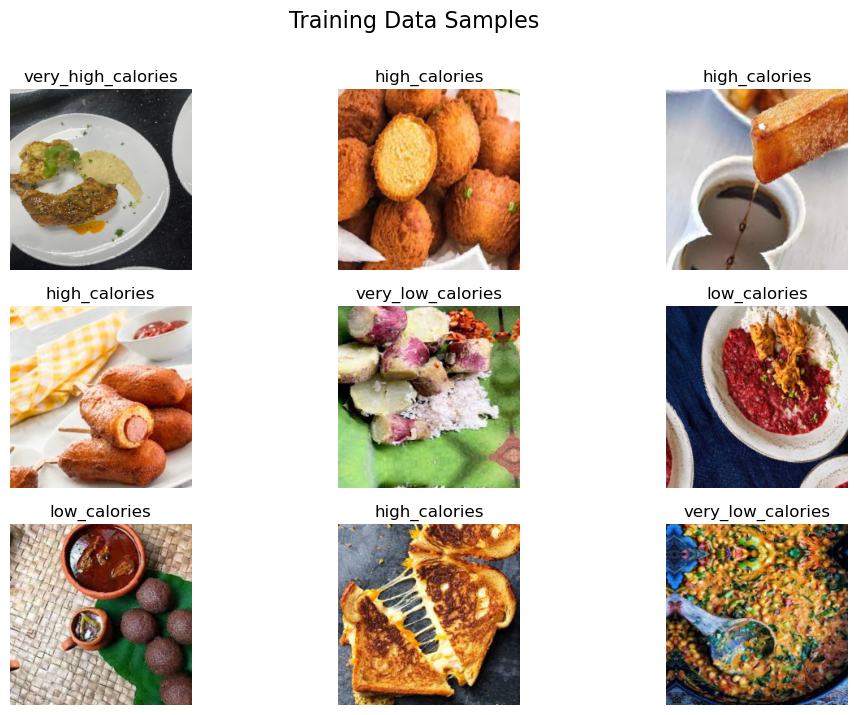

In [12]:
class_names = list(train_generator.class_indices.keys())
def plot_sample_images(generator, title):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        img, label = next(generator)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[0])
        plt.title(class_names[np.argmax(label[0])])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_sample_images(train_generator, "Training Data Samples")

# Load pretrained VGG16 model

In [25]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

In [27]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Model construction

In [29]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    base_model,                             # Pretrained VGG16
    Flatten(),                              # Flatten layer
    BatchNormalization(),                   # Normalize inputs to Dense layer
    Dense(512, activation='relu'),          # Increased units for Dense layer
    Dropout(0.5),                           # Reduced dropout rate
    Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

In [31]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,663,173 (105.53 MB)

 Trainable params: 12,898,309 (49.20 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

# Model training

In [35]:
EPOCHS = 20  # Increased epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.2116 - loss: 2.3799 - val_accuracy: 0.3846 - val_loss: 1.6458
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.2812 - loss: 2.3158

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 528ms/step - accuracy: 0.2812 - loss: 2.3158 - val_accuracy: 0.3846 - val_loss: 1.6326
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.3547 - loss: 1.9140 - val_accuracy: 0.5000 - val_loss: 1.4784
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 595ms/step - accuracy: 0.4062 - loss: 2.1887 - val_accuracy: 0.5000 - val_loss: 1.4667
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.4903 - loss: 1.5337 - val_accuracy: 0.5000 - val_loss: 1.3441
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 593ms/step - accuracy: 0.5000 - loss: 1.7725 - val_accuracy: 0.5000 - val_loss: 1.3325
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5583 - loss: 1.3170 - val_accuracy: 0.4615 - val_loss: 1.2208
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.6250 - loss: 1.5353 - val_accuracy: 0.4615 - val_loss: 1.1989
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5919 - loss: 1.3320 - val_accuracy: 0.5000 - val_loss: 1.1255
Epoch 10/20

# Save the Model

In [37]:
model.save('./model/bmimaintenance_model.h5')

# Training and Validation Metrics 

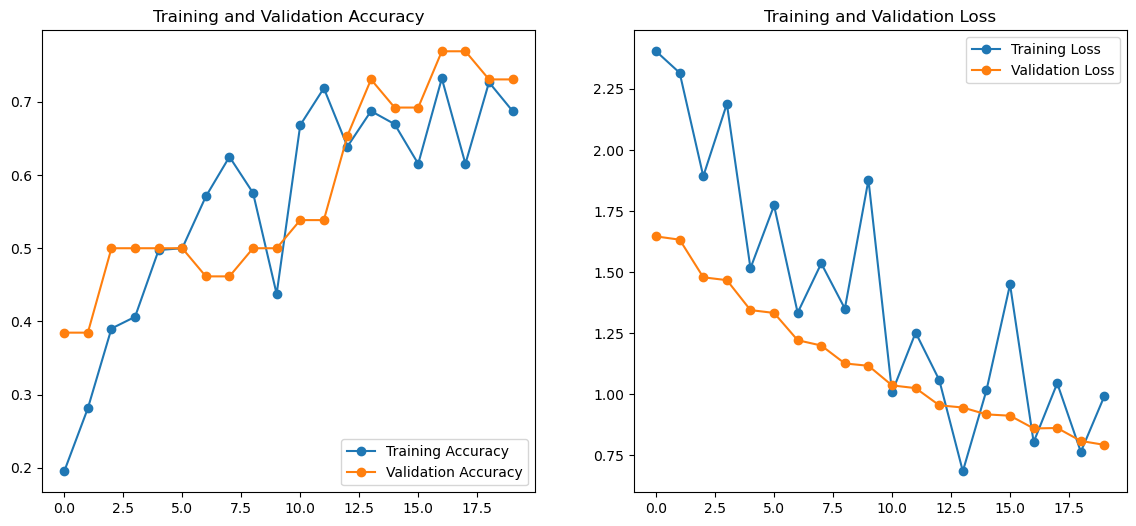

In [39]:
# Dynamically adjust for completed epochs
epochs_range = range(min(len(history.history['accuracy']), len(history.history['val_accuracy'])))

# Plot Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'][:len(epochs_range)], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'][:len(epochs_range)], label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'][:len(epochs_range)], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'][:len(epochs_range)], label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Evaluate the Model

In [41]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


# Confusion Matrix 

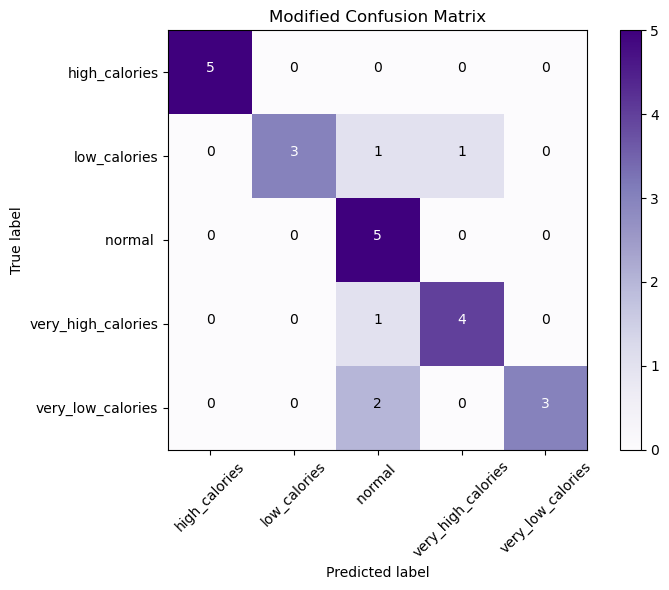

In [43]:
cm = confusion_matrix(true_classes, predicted_classes)
target_names = list(test_generator.class_indices.keys())

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Purples):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, target_names, title='Modified Confusion Matrix')

In [45]:
import pandas as pd
from sklearn.metrics import f1_score

# F1 Score 

In [47]:
f1 = f1_score(true_classes, predicted_classes, average=None)
f1_weig = f1_score(true_classes, predicted_classes, average='weighted')

# Create F1 score table
f1_table = pd.DataFrame({'Class': class_names, 'F1 Score': f1})
f1_table.loc[len(f1_table)] = ['weighted', f1_weig]

print("F1 Score Table:")
print(f1_table)

F1 Score Table:
                Class  F1 Score
0       high_calories  1.000000
1        low_calories  0.750000
2             normal   0.714286
3  very_high_calories  0.800000
4   very_low_calories  0.750000
5            weighted  0.802857


# Final Metrics 

In [49]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}")

Final Training Accuracy: 0.69
Final Validation Accuracy: 0.73


# Sample predict

First image to predict:


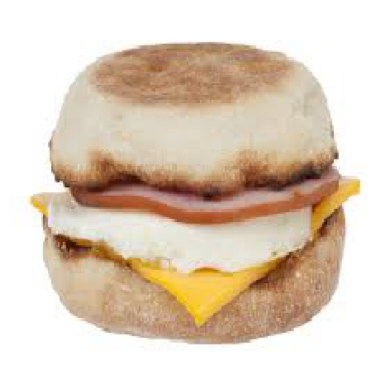

First image's actual label: high_calories
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: high_calories


In [51]:
images_batch, labels_batch = next(test_generator)

# Scale image data back to [0, 255] if normalized
if images_batch[0].max() <= 1.0:
    first_image = (images_batch[0] * 255).astype('uint8')
else:
    first_image = images_batch[0].astype('uint8')

# Get the first label
first_label = labels_batch[0]

# Display the first image
print("First image to predict:")
plt.imshow(first_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())
actual_label = class_names[np.argmax(first_label)]

# Print actual label
print("First image's actual label:", actual_label)

# Predict the batch
batch_prediction = model.predict(images_batch)
predicted_label_index = np.argmax(batch_prediction[0])
predicted_label = class_names[predicted_label_index]

# Print predicted label
print("Predicted label:", predicted_label)